In [1]:
import warnings
warnings.filterwarnings('ignore')

import urllib, json
from urllib.request import urlopen
import numpy as np
from io import open
import ast
import time
import requests
import pandas as pd

from IPython.core.display import HTML,display
display(HTML("<style>.container { width:85% !important; }</style>"))

%matplotlib inline

import matplotlib

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'


from collections import Counter

In [21]:
w = np.load("um_openalex.npy", allow_pickle=True)

In [22]:
authors = []
author_count = []
lead_um_works_count = 0
lead_um_works = []
country_codes = []
for work in w:
    count_authors = 0
    for author in work['authorships']:
        count_authors += 1
        country_codes.append(author['countries'])
        if 'institutions' in author.keys():
            for institution in author['institutions']:
                if institution['display_name'] == 'University of Maribor':
                    if author['is_corresponding'] == True or author['author_position'] == 'first':
                    #if author['author_position'] == 'first':
                        authors.append(author['author']['display_name'])
                        lead_um_works_count += 1
                        lead_um_works.append(work)
    author_count.append(count_authors)


In [27]:
# --- STEP 1: Build unique authors per year --- #
begin_year = 1990
end_year = 2024
# Create a dictionary to collect unique authors for each year.
authors_year = {year: set() for year in range(begin_year, end_year)}

for work in lead_um_works:
    pub_year = work.get("publication_year")
    if pub_year is None:
        continue  # Skip if there is no publication year
    # Only consider years within our range
    if begin_year <= pub_year < end_year:
        for authorship in work.get("authorships", []):
            # Check that institutions are present
            if "institutions" in authorship:
                for institution in authorship["institutions"]:
                    if institution.get("display_name") == "University of Maribor":
                        # Add the author’s display name to the set for that year.
                        authors_year[pub_year].add(authorship["author"]["display_name"])
                        # (Assuming the author’s name is unique across records)

# --- STEP 2: Compute Year-to-Year Retention --- #

# For each year, compute the fraction of authors who publish in the next year.
retention_rate = {}
for year in range(begin_year, end_year-1):  # up to 2023 because we need a next year
    current_authors = authors_year.get(year, set())
    next_authors = authors_year.get(year + 1, set())
    if current_authors:
        rate = len(current_authors.intersection(next_authors)) / len(current_authors)
        retention_rate[year] = rate
    else:
        retention_rate[year] = None  # or 0 if you prefer

print("Year-to-Year Retention Rates:")
for year in range(begin_year, end_year-1):
    rate = retention_rate[year]
    if rate is not None:
        print(f"  {year} -> {year+1}: {rate:.2%}")
    else:
        print(f"  {year} -> {year+1}: No data")

# --- STEP 3: Build Author Publication Histories --- #

# Create a mapping of each author to the list of years they have published.
author_years = {}
for year, authors in authors_year.items():
    for author in authors:
        author_years.setdefault(author, []).append(year)

# Sort the list of years for each author (so the first year is at index 0)
for author in author_years:
    author_years[author].sort()

# --- STEP 4: Compute Cohort Survival (Attrition) --- #

# Define cohorts: for each year, the set of authors for whom that year is the first publication year.
cohorts = {year: [] for year in range(begin_year, end_year)}
for author, years in author_years.items():
    first_year = years[0]
    cohorts[first_year].append(author)

# For each cohort, compute the survival fraction for each subsequent year.
# Here, "survival" means that an author from the cohort published in that later year.
cohort_survival = {}
for cohort_year, cohort_authors in cohorts.items():
    total_authors = len(cohort_authors)
    if total_authors == 0:
        continue  # Skip cohorts with no authors
    survival_data = {}
    # For each year from the cohort year until the end of our period:
    for year in range(cohort_year, end_year):
        # Count how many cohort authors are active in this year
        active_count = sum(1 for author in cohort_authors if year in author_years[author])
        survival_data[year] = active_count / total_authors
    cohort_survival[cohort_year] = survival_data

# --- STEP 5: Reporting the Cohort Survival Data --- #

print("\nCohort Survival Data:")
for cohort_year in sorted(cohort_survival.keys()):
    print(f"Cohort {cohort_year}:")
    for year in sorted(cohort_survival[cohort_year].keys()):
        survival_frac = cohort_survival[cohort_year][year]
        print(f"  Year {year}: {survival_frac:.2%}")

# --- Optional: Interpretations --- #
# - The year-to-year retention rate tells you, for example, that if 100 authors were active in 2010,
#   and 60 of them published in 2011, then the retention rate is 60%.
#
# - In the cohort survival data, if for the 2010 cohort you see:
#       2010: 100%, 2011: 70%, 2012: 50%, 2013: 40%, ...
#   it means that all authors in the 2010 cohort published in 2010 (by definition), 70% were active
#   in 2011, 50% in 2012, and so on.


Year-to-Year Retention Rates:
  1990 -> 1991: 28.57%
  1991 -> 1992: 34.85%
  1992 -> 1993: 31.34%
  1993 -> 1994: 20.31%
  1994 -> 1995: 28.74%
  1995 -> 1996: 29.09%
  1996 -> 1997: 38.18%
  1997 -> 1998: 36.57%
  1998 -> 1999: 39.49%
  1999 -> 2000: 36.22%
  2000 -> 2001: 41.09%
  2001 -> 2002: 54.63%
  2002 -> 2003: 48.77%
  2003 -> 2004: 50.25%
  2004 -> 2005: 54.59%
  2005 -> 2006: 50.79%
  2006 -> 2007: 49.57%
  2007 -> 2008: 48.17%
  2008 -> 2009: 52.02%
  2009 -> 2010: 51.29%
  2010 -> 2011: 55.17%
  2011 -> 2012: 50.85%
  2012 -> 2013: 51.43%
  2013 -> 2014: 51.47%
  2014 -> 2015: 51.36%
  2015 -> 2016: 50.86%
  2016 -> 2017: 53.56%
  2017 -> 2018: 49.67%
  2018 -> 2019: 52.85%
  2019 -> 2020: 58.50%
  2020 -> 2021: 56.45%
  2021 -> 2022: 49.63%
  2022 -> 2023: 47.17%

Cohort Survival Data:
Cohort 1990:
  Year 1990: 100.00%
  Year 1991: 28.57%
  Year 1992: 32.65%
  Year 1993: 20.41%
  Year 1994: 26.53%
  Year 1995: 26.53%
  Year 1996: 34.69%
  Year 1997: 30.61%
  Year 1998: 3

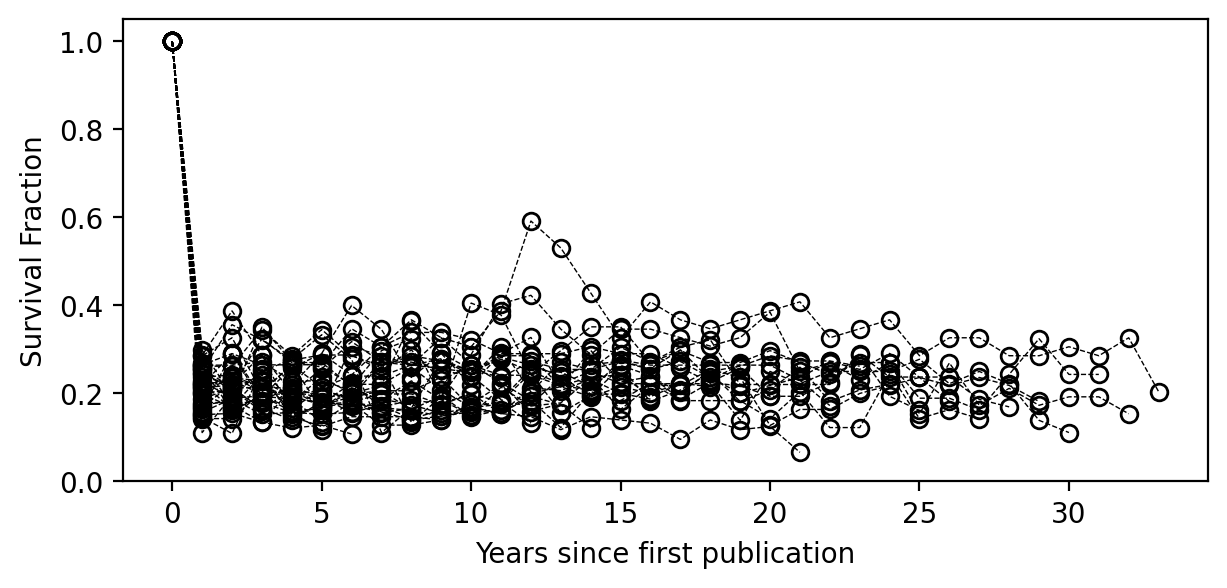

In [31]:


plt.figure(figsize=(7, 3))

# Plot each cohort's survival curve, shifting the x-axis to relative time.
for cohort_year, survival_data in sorted(cohort_survival.items()):
    # Convert absolute publication years to "years since first publication" (relative time).
    # For each year in the survival data, compute t = year - cohort_year.
    relative_years = [year - cohort_year for year in sorted(survival_data.keys())]
    survival_rates = [survival_data[year] for year in sorted(survival_data.keys())]
    
    plt.plot(relative_years, survival_rates, marker='o', label=f'Cohort {cohort_year}', ms=6, lw=0.5, ls='--', mfc='none', color='black')

# Set plot labels and title.
plt.xlabel("Years since first publication")
plt.ylabel("Survival Fraction")
#plt.title("Author Cohort Survival Curves (Aligned at t=0)")
#plt.grid(True)
plt.ylim(0, 1.05)  # y-axis from 0 to slightly above 1 to account for 100%

# Display a legend indicating each cohort.
#plt.legend(title="Cohort Year", loc='best')

# Show the plot.
plt.show()


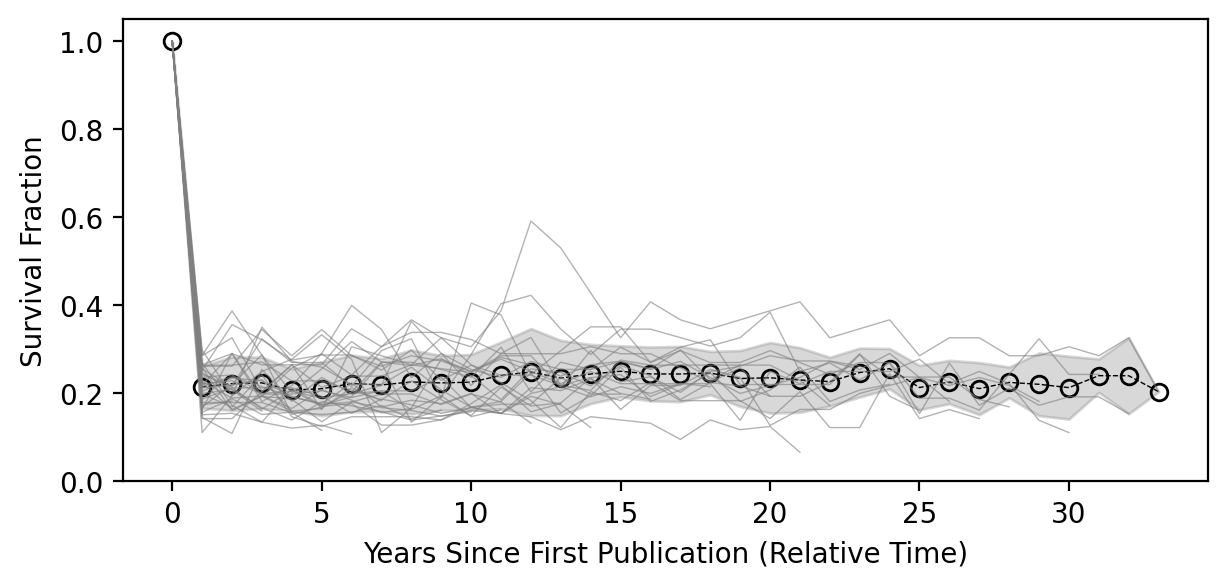

In [36]:


# --- Step 1: Convert to Relative Time --- #
# Create a dictionary that maps relative time (t) to a list of survival fractions from different cohorts.
relative_survival = {}  # key: relative time t, value: list of survival fractions at that t
for cohort_year, survival_dict in cohort_survival.items():
    for abs_year, surv_frac in survival_dict.items():
        t = abs_year - cohort_year  # convert to relative time
        if t not in relative_survival:
            relative_survival[t] = []
        relative_survival[t].append(surv_frac)

# --- Step 2: Compute Mean and Standard Deviation for Each Relative Time --- #
# Sort the relative time values and compute statistics for each t.
t_values = sorted(relative_survival.keys())
mean_survival = [np.mean(relative_survival[t]) for t in t_values]
std_survival  = [np.std(relative_survival[t]) for t in t_values]

# --- Step 3: Plot the Mean Survival Curve with Error Area --- #
plt.figure(figsize=(7, 3))

# Plot the mean survival curve.
plt.plot(t_values, mean_survival, marker='o', linestyle='--', color='black', label='Mean Survival', lw=0.5, ms=6, mfc='none')

# Compute the upper and lower bounds for the error area.
mean_minus_std = [m - s for m, s in zip(mean_survival, std_survival)]
mean_plus_std  = [m + s for m, s in zip(mean_survival, std_survival)]

# Plot the error area as a gray filled region.
plt.fill_between(t_values, mean_minus_std, mean_plus_std, color='gray', alpha=0.3, label='±1 Std Dev')

for cohort_year, survival_data in sorted(cohort_survival.items()):
    # Convert absolute publication years to "years since first publication" (relative time).
    # For each year in the survival data, compute t = year - cohort_year.
    relative_years = [year - cohort_year for year in sorted(survival_data.keys())]
    survival_rates = [survival_data[year] for year in sorted(survival_data.keys())]
    
    plt.plot(relative_years, survival_rates, marker='', label=f'Cohort {cohort_year}', ms=6, lw=0.5, ls='-', mfc='none', color='gray', alpha=0.6)   

# Labeling the plot.
plt.xlabel("Years Since First Publication (Relative Time)")
plt.ylabel("Survival Fraction")
#plt.title("Mean Author Cohort Survival Curve with Error Area")
plt.ylim(0, 1.05)
#plt.grid(True)
#plt.legend(loc='best')

# Display the plot.
plt.show()


In [151]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

begin_year = 1990
end_year = 2024
# Create a dictionary to collect unique authors for each year.
authors_year = {year: set() for year in range(begin_year, end_year)}

for work in lead_um_works:
    pub_year = work.get("publication_year")
    if pub_year is None:
        continue  # Skip if there is no publication year
    # Only consider years within our range
    if begin_year <= pub_year < end_year:
        for authorship in work.get("authorships", []):
            # Check that institutions are present
            if "institutions" in authorship:
                for institution in authorship["institutions"]:
                    if institution.get("display_name") == "University of Maribor":
                        # Add the author’s display name to the set for that year.
                        authors_year[pub_year].add(authorship["author"]["display_name"])
                        # (Assuming the author’s name is unique across records)

# Create a mapping of each author to the list of years they have published.
author_years = {}
for year, authors in authors_year.items():
    for author in authors:
        author_years.setdefault(author, []).append(year)

# Sort the list of years for each author (so the first year is at index 0)
for author in author_years:
    author_years[author].sort()

# --- Prepare the Data ---
# Define the last observation (censoring) year.
max_obs_year = end_year - 1

# Create a list of records (one per author)
records = []
for author, years in author_years.items():
    # Ensure the publication years are sorted
    years.sort()
    debut = years[0]
    last = years[-1]
    # Compute time as the difference (in years) between first and last publication.
    # This is our "survival time" (years since debut).
    t = last - debut
    # Determine event:
    # If the last publication is the max observed year, we consider that the author is censored.
    # Otherwise, we treat it as a dropout event.
    event = 0 if last == max_obs_year else 1
    records.append({'author': author, 'time': t, 'event': event})

# Convert to a DataFrame
df = pd.DataFrame(records)
"""
print("Survival Data:")
print(df)
"""
# --- Kaplan-Meier Estimate ---
kmf = KaplanMeierFitter()
kmf.fit(durations=df['time'], event_observed=df['event'], label='KM Estimate')

"""
# --- Plotting ---
ax = kmf.plot_survival_function(ci_show=True, 
                                ci_alpha=0.3, 
                                color='blue', 
                                marker='o', 
                                markersize=5)
ax.set_title("Kaplan–Meier Survival Estimate of Author Publishing Activity")
ax.set_xlabel("Years since first publication")
ax.set_ylabel("Survival Probability (still publishing)")
ax.set_ylim(0, 1.05)
plt.grid(True)
plt.show()
"""

'\n# --- Plotting ---\nax = kmf.plot_survival_function(ci_show=True, \n                                ci_alpha=0.3, \n                                color=\'blue\', \n                                marker=\'o\', \n                                markersize=5)\nax.set_title("Kaplan–Meier Survival Estimate of Author Publishing Activity")\nax.set_xlabel("Years since first publication")\nax.set_ylabel("Survival Probability (still publishing)")\nax.set_ylim(0, 1.05)\nplt.grid(True)\nplt.show()\n'

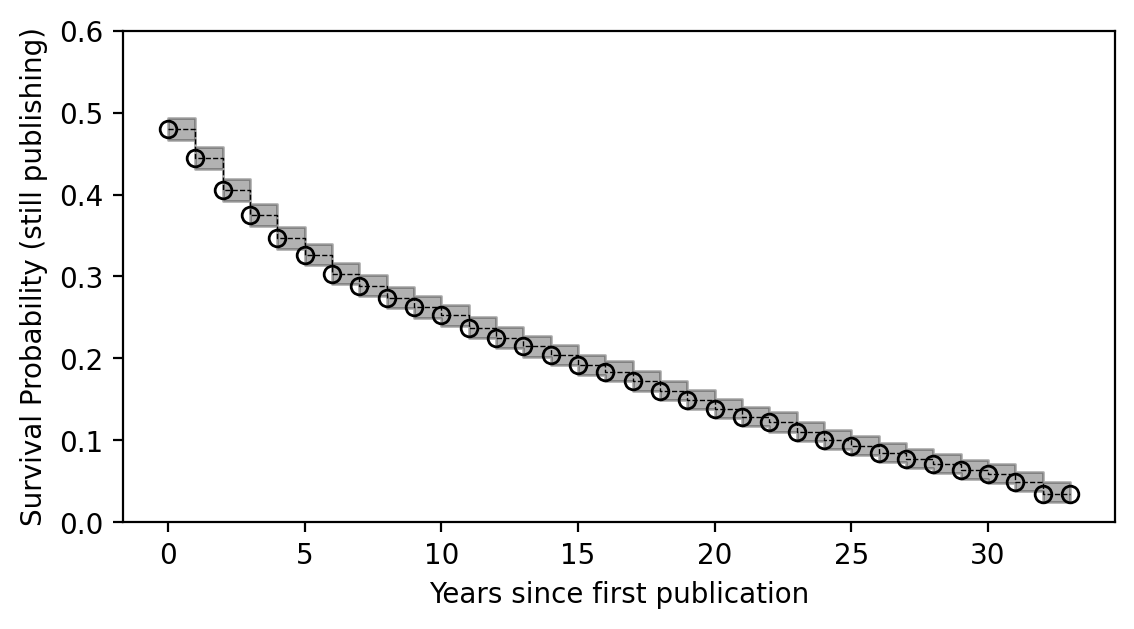

In [152]:
# --- Plotting ---
ax = kmf.plot_survival_function(ci_show=True, 
                                ci_alpha=0.3, 
                                color='black', 
                                marker='o', 
                                markersize=6, mfc='none', legend=False, ls='--', lw=0.5)
#ax.set_title("Kaplan–Meier Survival Estimate of Author Publishing Activity")
ax.set_xlabel("Years since first publication")
ax.set_ylabel("Survival Probability (still publishing)")
ax.set_ylim(0.0,0.6)
ax.set_aspect(aspect=30)
#plt.grid(True)
plt.show()


Text(0, 0.5, 'cond. survival prob., S(t)/S(0)')

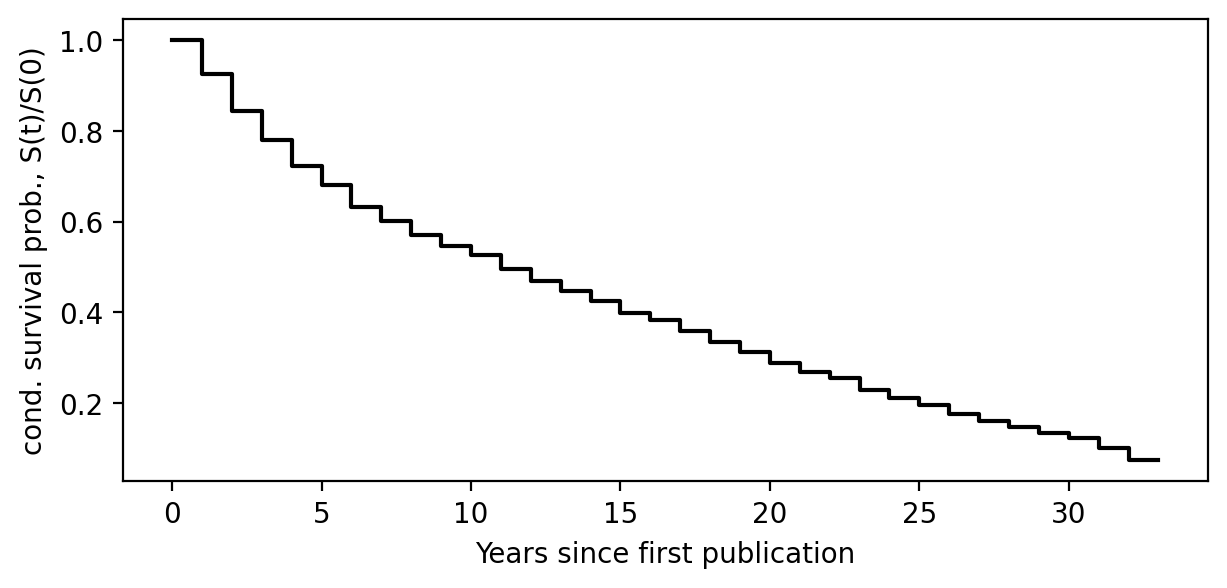

In [ ]:
# plot the survival function
plt.figure(figsize=(7, 3))
plt.step(kmf.survival_function_.index, kmf.survival_function_['KM Estimate']/kmf.survival_function_['KM Estimate'][0] , where="post", color='black', lw=1.5)
plt.xlabel("Years since first publication")
plt.ylabel("cond. survival prob., S(t)/S(0)")
# plt.title("Kaplan-Meier Survival Estimate of Author Publishing Activity")


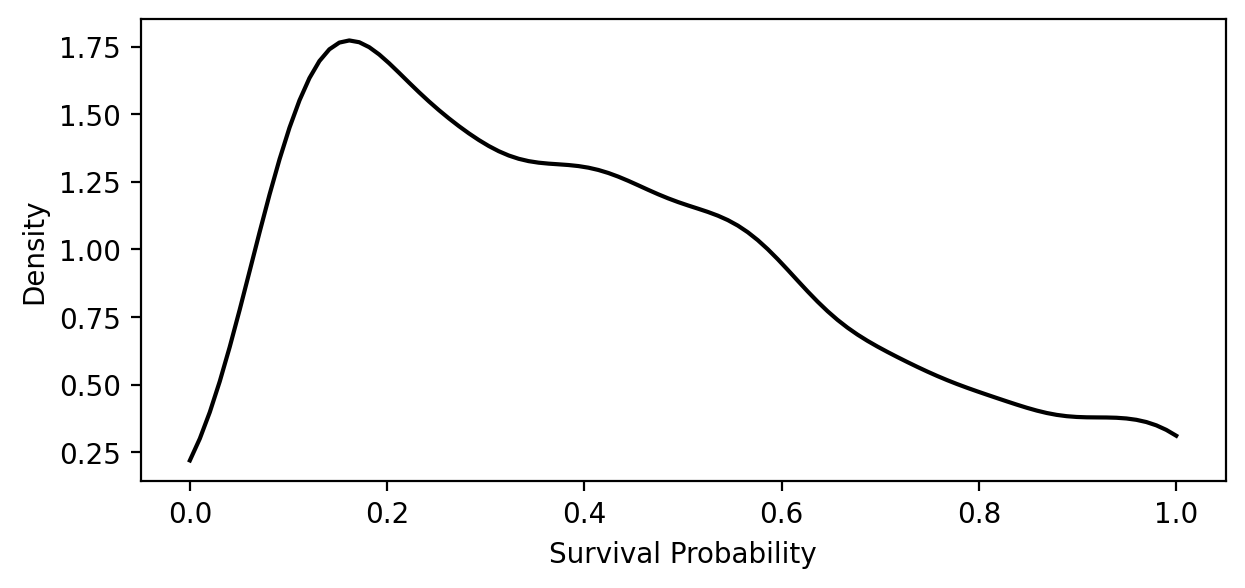

"\n# Option 2: Using Seaborn for a quick KDE plot\nplt.figure(figsize=(8, 4))\nsns.kdeplot(surv_probs, bw_adjust=0.5, fill=True, color='skyblue')\nplt.xlabel('Survival Probability')\nplt.ylabel('Density')\nplt.title('Kernel Density Estimate (Seaborn) of Survival Probabilities')\nplt.show()\n"

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from scipy.stats import gaussian_kde
import seaborn as sns
# Extract the survival probabilities from the fitted model
# kmf.survival_function_ is a DataFrame indexed by unique time points.
time_points = kmf.survival_function_.index.values
surv_probs = kmf.survival_function_['KM Estimate'].values / kmf.survival_function_['KM Estimate'].values[0]
"""
# Plot the Kaplan-Meier curve for reference
plt.figure(figsize=(8, 4))
plt.step(time_points, surv_probs, where='post', label='Kaplan-Meier')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Kaplan-Meier Survival Curve')
plt.legend()
plt.show()
"""
# Now, use kernel density estimation to estimate the density of survival probabilities.
# Note: These survival probabilities are on the interval [0,1].
kde = gaussian_kde(surv_probs, bw_method=.2)
x_grid = np.linspace(0, 1, 100)
#x_grid = x_grid * time_points.max()
density = kde(x_grid)

# Option 1: Using Matplotlib directly
plt.figure(figsize=(7, 3))
# x axis are years since first publication, transform from x_grid to years
# normalize density to sum to 1 with respect to the x_grid

plt.plot(x_grid, density, color='black', lw=1.5)
#plt.plot(x_grid, density, color='blue', lw=2)
plt.xlabel('Survival Probability')
plt.ylabel('Density')
#plt.title('Kernel Density Estimate of Survival Probabilities')

# inverse funtion of surv_probs to get the time points in years

plt.show()
"""
# Option 2: Using Seaborn for a quick KDE plot
plt.figure(figsize=(8, 4))
sns.kdeplot(surv_probs, bw_adjust=0.5, fill=True, color='skyblue')
plt.xlabel('Survival Probability')
plt.ylabel('Density')
plt.title('Kernel Density Estimate (Seaborn) of Survival Probabilities')
plt.show()
"""
# plot 

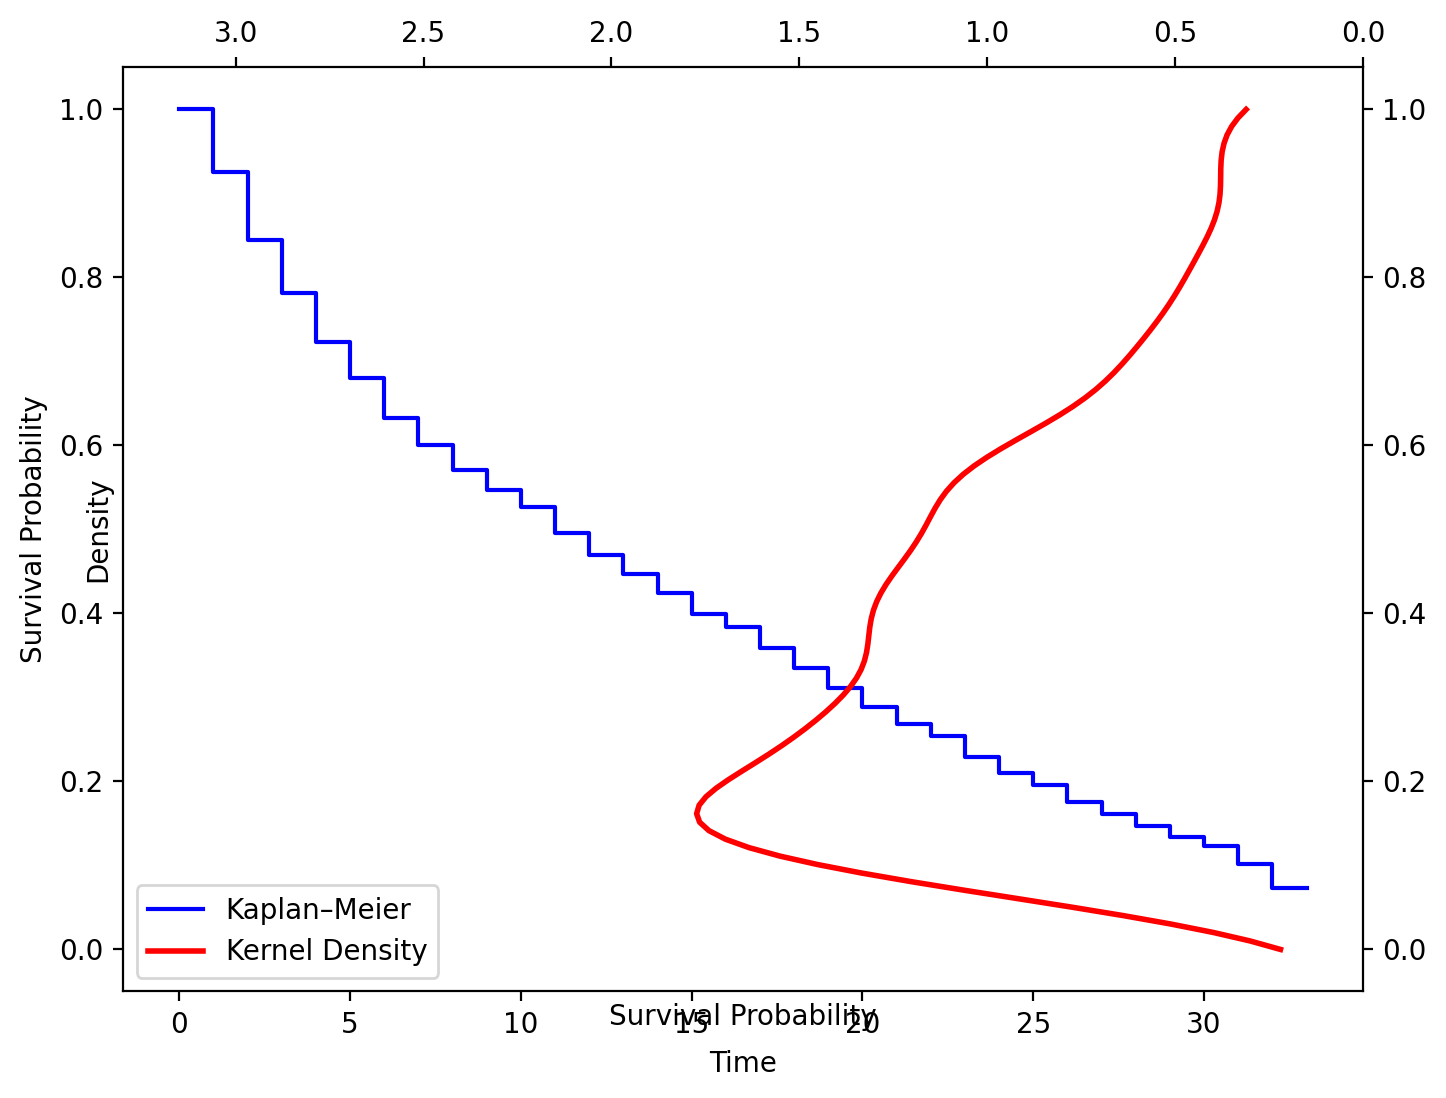

In [176]:
# --- Create the figure and primary axes (for the KM survival curve)
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.step(time_points, surv_probs, where='post', color='blue', label='Kaplan–Meier')
ax1.set_xlabel("Time")
ax1.set_ylabel("Survival Probability")
#ax1.set_title("Kaplan–Meier Survival Function and Density of S(t)")

# --- Create secondary axes for the kernel density plot
pos = ax1.get_position()  # get the position of ax1
ax2 = fig.add_axes(pos, label="density", frameon=False)
ax2.plot(density, x_grid, color='red', lw=2, label='Kernel Density')
ax2.set_xlabel("Survival Probability")  # top x-axis
ax2.set_ylabel("Density")               # right y-axis

# Place the new axes' ticks on top and right
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()

# Hide the bottom and left spines of ax2
ax2.spines["bottom"].set_visible(False)
ax2.spines["left"].set_visible(False)

# Align ax2's x-axis with ax1's y-axis:
ax2.set_xlim([0, 3.3])

# Reverse the kernel density x-axis:
ax2.invert_xaxis()

ax1.set_ylim(-0.05, 1.05)
ax2.set_ylim(-0.05, 1.05)

# Add legends combining both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left')

plt.show()

In [192]:
data_kwiek_w = pd.read_csv('data_kwiek_w.csv', header=None)
data_kwiek_m = pd.read_csv('data_kwiek_m.csv', header=None)

In [190]:
data_kwiek

,0,1
0,0.000000,1.000000
1,1.021518,0.998227
2,1.046433,0.953901
3,1.968290,0.952128
4,2.092865,0.875887
5,2.964892,0.875887
6,3.039638,0.797872
7,3.986410,0.796099
8,4.036240,0.728723
9,4.958097,0.726950


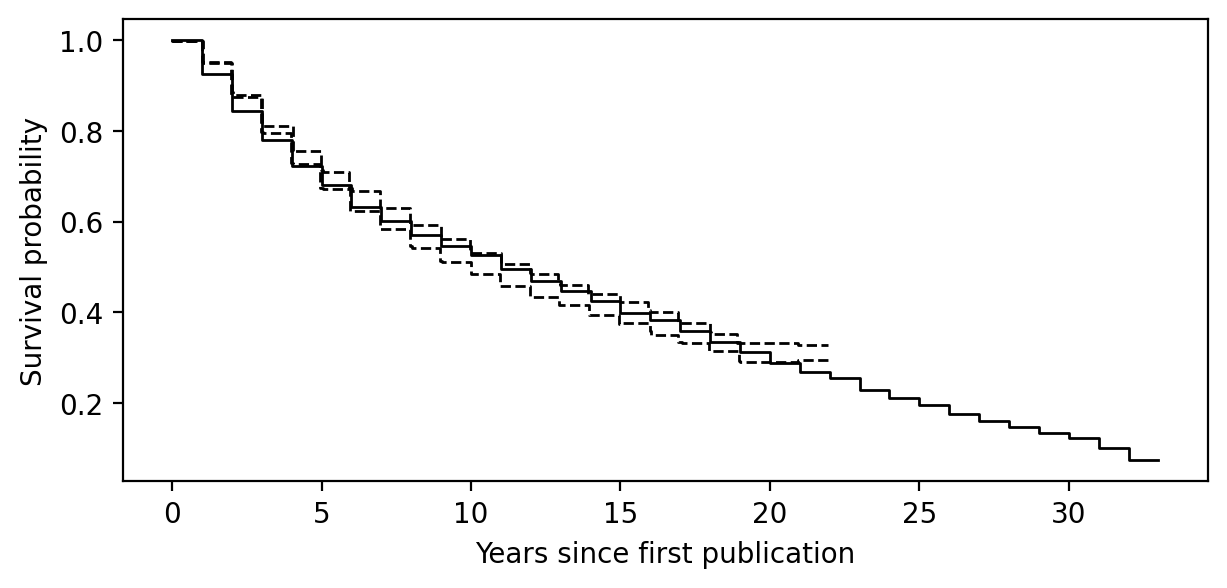

In [198]:
# plot data_kwiek
plt.figure(figsize=(7, 3))
plt.step(data_kwiek_w[0], data_kwiek_w[1], color='black', lw=1., ls='--')
plt.step(data_kwiek_m[0], data_kwiek_m[1], color='black', lw=1., ls='--')
plt.xlabel("Years since first publication")
plt.ylabel("Survival probability")
plt.step(kmf.survival_function_.index, kmf.survival_function_['KM Estimate']/kmf.survival_function_['KM Estimate'][0] , where="post", color='black', lw=1.)
